### Import Library

In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

import re
from tqdm import tqdm

In [350]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [351]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15123831214620817953
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5919240555139519142
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import data

In [352]:
data = pd.read_csv("data/data.csv")

In [353]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_C,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0


### Processing missing data & Drop unnecessary data

In [354]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

In [355]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [356]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [357]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [358]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [359]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [360]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 670 to 1162
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1031 non-null   float64
 1   As              1031 non-null   float64
 2   slope           1031 non-null   float64
 3   altitude        1031 non-null   float64
 4   profile_c_num   1031 non-null   float64
 5   profile_c_abs   1031 non-null   int64  
 6   planform_c_num  1031 non-null   float64
 7   planform_c_abs  1031 non-null   int64  
 8   HYDGRP_A        1031 non-null   int64  
 9   HYDGRP_B        1031 non-null   int64  
 10  HYDGRP_C        1031 non-null   int64  
 11  HYDGRP_D        1031 non-null   int64  
 12  SOL_K1          1031 non-null   float64
 13  CLAY1           1031 non-null   float64
 14  SILT1           1031 non-null   float64
 15  SAND1           1031 non-null   float64
 16  ROCK1           1031 non-null   float64
dtypes: float64(11), int64(6)
memory

In [361]:
As_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 960 to 353
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              225 non-null    float64
 1   slope           225 non-null    float64
 2   altitude        225 non-null    float64
 3   profile_c_num   225 non-null    float64
 4   profile_c_abs   225 non-null    int64  
 5   planform_c_num  225 non-null    float64
 6   planform_c_abs  225 non-null    int64  
 7   HYDGRP_A        225 non-null    int64  
 8   HYDGRP_B        225 non-null    int64  
 9   HYDGRP_C        225 non-null    int64  
 10  HYDGRP_D        225 non-null    int64  
 11  SOL_K1          225 non-null    float64
 12  CLAY1           225 non-null    float64
 13  SILT1           225 non-null    float64
 14  SAND1           225 non-null    float64
 15  ROCK1           225 non-null    float64
dtypes: float64(10), int64(6)
memory usage: 29.9 KB


### Check the value skewed

#### As

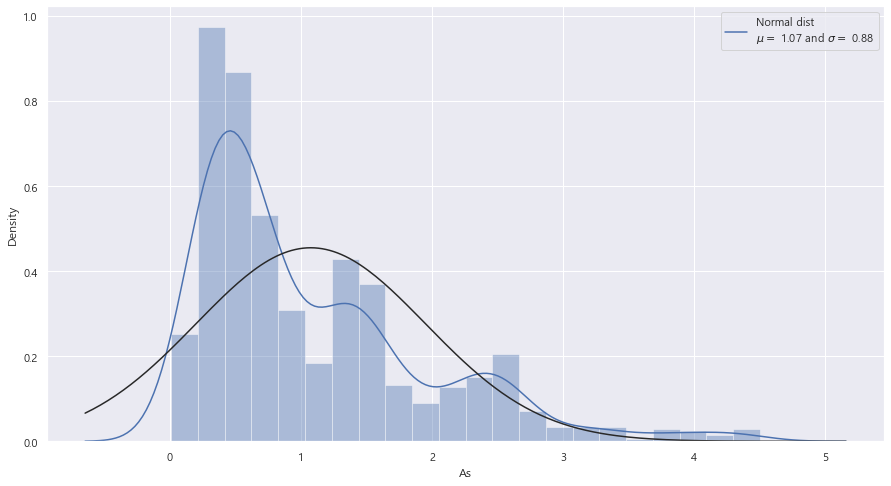

In [362]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

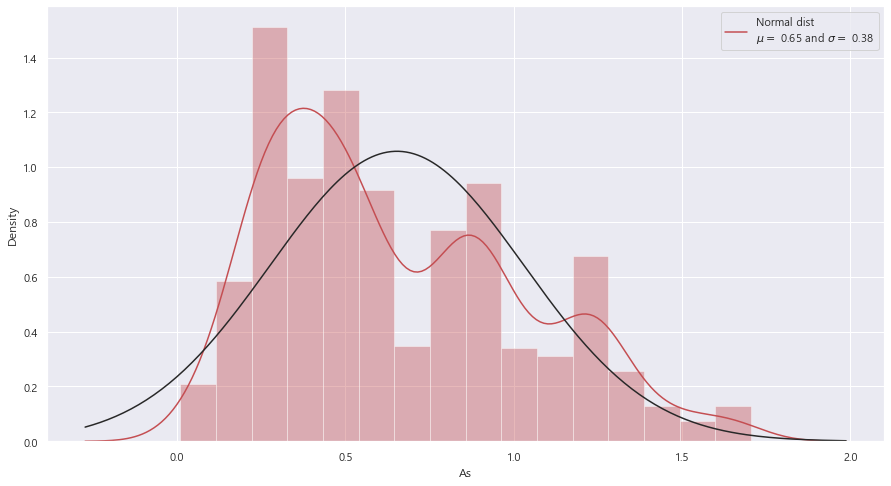

In [363]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

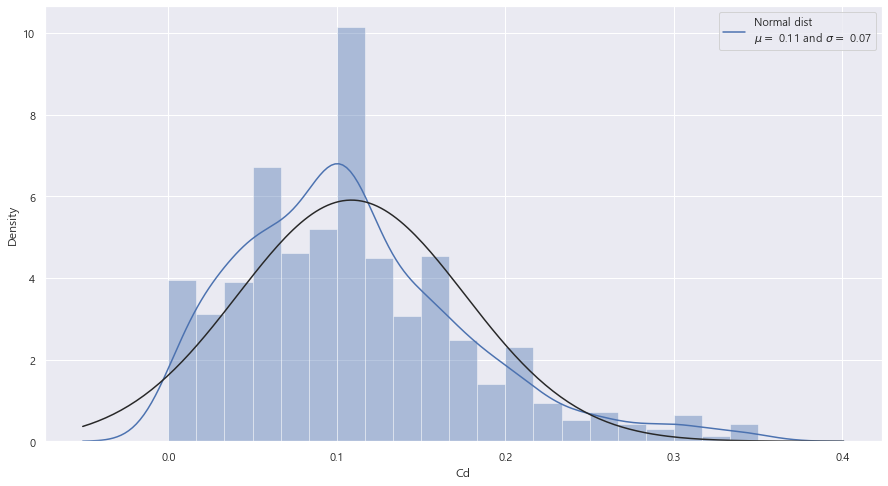

In [364]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

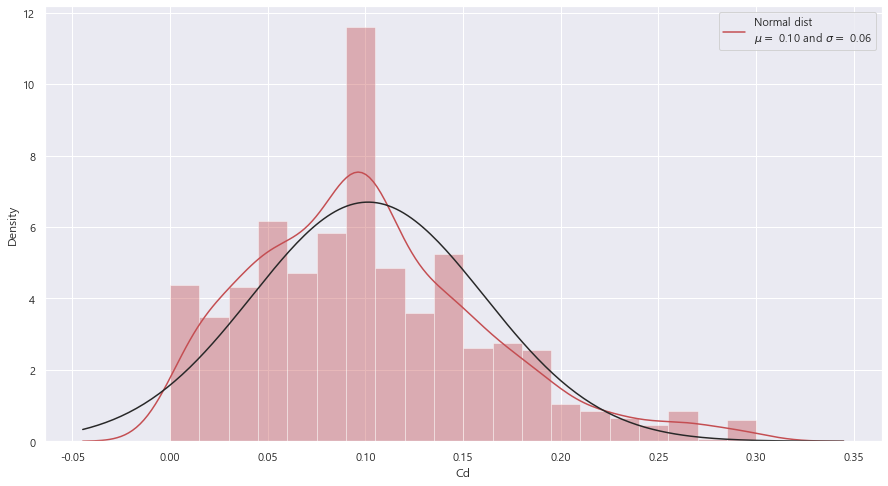

In [365]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

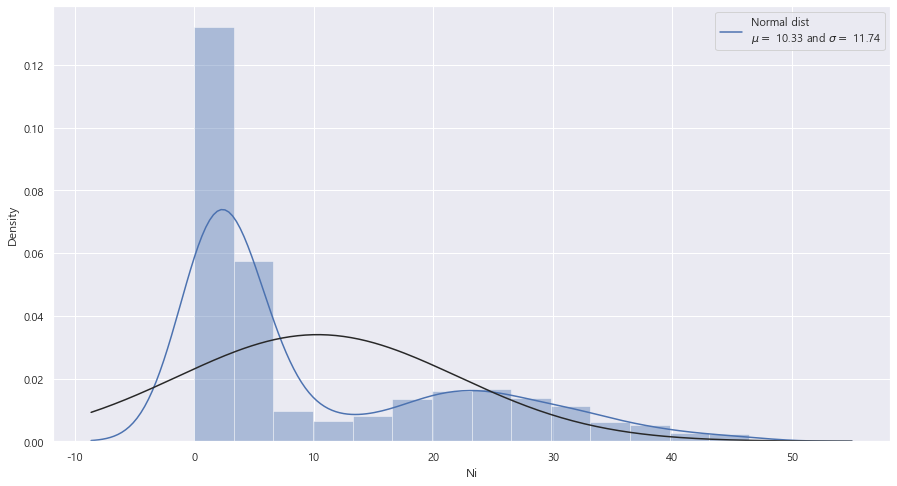

In [366]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

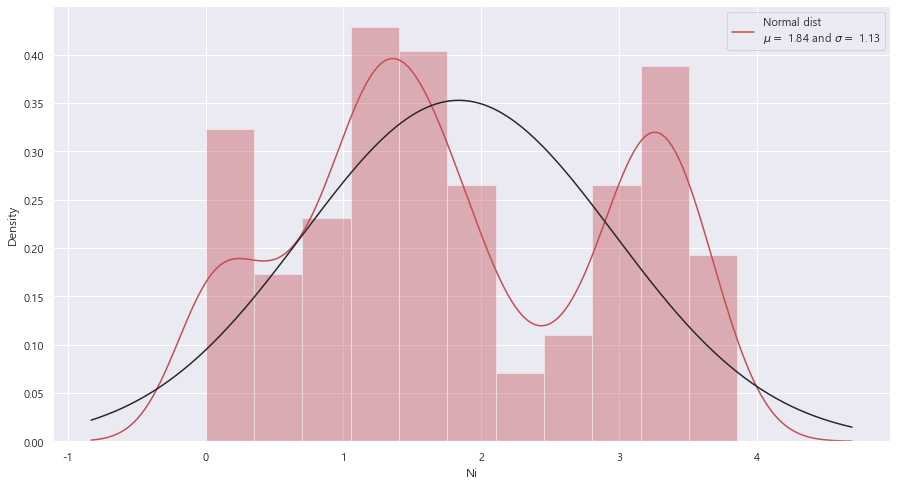

In [367]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [368]:

As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

"""
As_train.altitude = np.log1p(As_train.altitude)
Cd_train.altitude = np.log1p(Cd_train.altitude)
Ni_train.altitude = np.log1p(Ni_train.altitude)

As_train.slope = np.log1p(As_train.slope)
Cd_train.slope = np.log1p(Cd_train.slope)
Ni_train.slope = np.log1p(Ni_train.slope)
"""

'\nAs_train.altitude = np.log1p(As_train.altitude)\nCd_train.altitude = np.log1p(Cd_train.altitude)\nNi_train.altitude = np.log1p(Ni_train.altitude)\n\nAs_train.slope = np.log1p(As_train.slope)\nCd_train.slope = np.log1p(Cd_train.slope)\nNi_train.slope = np.log1p(Ni_train.slope)\n'

#### Scaling

In [369]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [370]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

As_X = pd.DataFrame(scaler.fit_transform(As_X), columns=As_X.columns)
Cd_X = pd.DataFrame(scaler.fit_transform(Cd_X), columns=Cd_X.columns)
Ni_X = pd.DataFrame(scaler.fit_transform(Ni_X), columns=Ni_X.columns)

#### 10-Fold Crossvalidation

In [371]:
kf = KFold(n_splits = 10, random_state = 605, shuffle = True)

#### 1) NGBRegressor

In [372]:
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

def ngb_model(test, X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.001)
    
    ngb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        ngb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 20
        ngb_pred += sub_pred

    print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{ngb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return ngb_pred

In [373]:
As_ngb_pred = ngb_model(As_test, As_X, As_y)

[iter 0] loss=0.4502 val_loss=0.0000 scale=1.0000 norm=0.5692
[iter 100] loss=0.4327 val_loss=0.0000 scale=1.0000 norm=0.5560
[iter 200] loss=0.4172 val_loss=0.0000 scale=1.0000 norm=0.5453
[iter 300] loss=0.4028 val_loss=0.0000 scale=1.0000 norm=0.5360
[iter 400] loss=0.3898 val_loss=0.0000 scale=1.0000 norm=0.5292
[iter 500] loss=0.3770 val_loss=0.0000 scale=1.0000 norm=0.5231
[iter 600] loss=0.3623 val_loss=0.0000 scale=2.0000 norm=1.0344
[iter 700] loss=0.3495 val_loss=0.0000 scale=1.0000 norm=0.5127
[iter 800] loss=0.3382 val_loss=0.0000 scale=2.0000 norm=1.0189
[iter 900] loss=0.3272 val_loss=0.0000 scale=2.0000 norm=1.0128
[iter 0] loss=0.3266 val_loss=0.0000 scale=2.0000 norm=1.0240
[iter 100] loss=0.3177 val_loss=0.0000 scale=2.0000 norm=1.0182
[iter 200] loss=0.3112 val_loss=0.0000 scale=2.0000 norm=1.0150
[iter 300] loss=0.3055 val_loss=0.0000 scale=1.0000 norm=0.5059
[iter 400] loss=0.2987 val_loss=0.0000 scale=2.0000 norm=1.0074
[iter 500] loss=0.2922 val_loss=0.0000 scale

In [374]:
Cd_ngb_pred = ngb_model(Cd_test, Cd_X, Cd_y)

[iter 0] loss=-1.3999 val_loss=0.0000 scale=2.0000 norm=0.9974
[iter 100] loss=-1.4197 val_loss=0.0000 scale=1.0000 norm=0.4814
[iter 200] loss=-1.4355 val_loss=0.0000 scale=1.0000 norm=0.4700
[iter 300] loss=-1.4478 val_loss=0.0000 scale=1.0000 norm=0.4629
[iter 400] loss=-1.4606 val_loss=0.0000 scale=1.0000 norm=0.4558
[iter 500] loss=-1.4713 val_loss=0.0000 scale=1.0000 norm=0.4506
[iter 600] loss=-1.4832 val_loss=0.0000 scale=1.0000 norm=0.4454
[iter 700] loss=-1.4971 val_loss=0.0000 scale=2.0000 norm=0.8801
[iter 800] loss=-1.5089 val_loss=0.0000 scale=2.0000 norm=0.8727
[iter 900] loss=-1.5198 val_loss=0.0000 scale=1.0000 norm=0.4332
[iter 0] loss=-1.5222 val_loss=0.0000 scale=1.0000 norm=0.4455
[iter 100] loss=-1.5327 val_loss=0.0000 scale=1.0000 norm=0.4408
[iter 200] loss=-1.5420 val_loss=0.0000 scale=1.0000 norm=0.4372
[iter 300] loss=-1.5504 val_loss=0.0000 scale=1.0000 norm=0.4350
[iter 400] loss=-1.5577 val_loss=0.0000 scale=1.0000 norm=0.4340
[iter 500] loss=-1.5644 val_l

In [375]:
Ni_ngb_pred = ngb_model(Ni_test, Ni_X, Ni_y)

[iter 0] loss=1.5420 val_loss=0.0000 scale=1.0000 norm=1.1034
[iter 100] loss=1.5159 val_loss=0.0000 scale=1.0000 norm=1.0780
[iter 200] loss=1.4922 val_loss=0.0000 scale=1.0000 norm=1.0557
[iter 300] loss=1.4714 val_loss=0.0000 scale=1.0000 norm=1.0376
[iter 400] loss=1.4489 val_loss=0.0000 scale=1.0000 norm=1.0175
[iter 500] loss=1.4309 val_loss=0.0000 scale=1.0000 norm=1.0022
[iter 600] loss=1.4143 val_loss=0.0000 scale=2.0000 norm=1.9777
[iter 700] loss=1.3966 val_loss=0.0000 scale=1.0000 norm=0.9754
[iter 800] loss=1.3781 val_loss=0.0000 scale=2.0000 norm=1.9239
[iter 900] loss=1.3554 val_loss=0.0000 scale=2.0000 norm=1.8932
[iter 0] loss=1.3558 val_loss=0.0000 scale=1.0000 norm=0.9474
[iter 100] loss=1.3424 val_loss=0.0000 scale=1.0000 norm=0.9391
[iter 200] loss=1.3306 val_loss=0.0000 scale=1.0000 norm=0.9319
[iter 300] loss=1.3184 val_loss=0.0000 scale=1.0000 norm=0.9251
[iter 400] loss=1.3056 val_loss=0.0000 scale=1.0000 norm=0.9181
[iter 500] loss=1.2944 val_loss=0.0000 scale

#### 2) RandomForestRegressor

In [376]:
def rf_model(test, X, y):
    rf = RandomForestRegressor(random_state = 605, n_estimators = 500)
    
    rf_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        rf.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(test)]) / 10
        rf_pred += sub_pred

    print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{rf.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return rf_pred

In [377]:
As_rf_pred = rf_model(As_test, As_X, As_y)

RandomForestRegressor의 10fold 평균 RMSE는 0.8463864493144397, RandomForestRegressor의 10fold 평균 R2 score는 -1.0125331526039525


In [378]:
Cd_rf_pred = rf_model(Cd_test, Cd_X, Cd_y)

RandomForestRegressor의 10fold 평균 RMSE는 0.06610252846589851, RandomForestRegressor의 10fold 평균 R2 score는 -0.013062292844136602


In [379]:
Ni_rf_pred = rf_model(Ni_test, Ni_X, Ni_y)

RandomForestRegressor의 10fold 평균 RMSE는 9.058864042106546, RandomForestRegressor의 10fold 평균 R2 score는 -51.456965859165585


#### 3) ExtraTreesRegressor

In [380]:
etc = ExtraTreesRegressor(random_state = 605, n_estimators = 500)

In [381]:
def etc_model(test, X, y):
    etc = ExtraTreesRegressor(random_state = 605, n_estimators = 500)
    
    etc_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        etc.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(test)]) / 10
        etc_pred += sub_pred

    print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{etc.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return etc_pred

In [382]:
As_etc_pred = etc_model(As_test, As_X, As_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 0.8645091082699965, ExtraTreesRegressor의 10fold 평균 R2 score는 -1.659096218263657


In [383]:
Cd_etc_pred = etc_model(Cd_test, Cd_X, Cd_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 0.06848200094132723, ExtraTreesRegressor의 10fold 평균 R2 score는 -0.12777628122135137


In [384]:
Ni_etc_pred = etc_model(Ni_test, Ni_X, Ni_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 8.345576736157522, ExtraTreesRegressor의 10fold 평균 R2 score는 -72.5633094522582


#### 4) GradientBoostingRegressor

In [385]:
def gb_model(test, X, y):
    gb = GradientBoostingRegressor(random_state = 605, max_depth = 5)
    
    gb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(test)]) / 10
        gb_pred += sub_pred

    print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{gb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return gb_pred

In [386]:
As_gb_pred = gb_model(As_test, As_X, As_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 0.8860089504373398, GradientBoostingRegressor의 10fold 평균 R2 score는 -1.4161478803269487


In [387]:
Cd_gb_pred = gb_model(Cd_test, Cd_X, Cd_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 0.0688758487694809, GradientBoostingRegressor의 10fold 평균 R2 score는 -0.11073358013770507


In [388]:
Ni_gb_pred = gb_model(Ni_test, Ni_X, Ni_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 9.17201032966133, GradientBoostingRegressor의 10fold 평균 R2 score는 -62.03462418420846


#### 5) CatBoostRegressor

In [389]:
def cb_model(test, X, y):
    cb = CatBoostRegressor(random_state = 605, silent = True, depth = 3)
    
    cb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        cb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(test)]) / 10
        cb_pred += sub_pred

    print(f'{cb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{cb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return cb_pred

In [390]:
As_cb_pred = cb_model(As_test, As_X, As_y)

CatBoostRegressor의 10fold 평균 RMSE는 0.8812109275947853, CatBoostRegressor의 10fold 평균 R2 score는 -1.1548710405143745


In [391]:
Cd_cb_pred = cb_model(Cd_test, Cd_X, Cd_y)

CatBoostRegressor의 10fold 평균 RMSE는 0.06809705357988562, CatBoostRegressor의 10fold 평균 R2 score는 -0.07162962634375783


In [392]:
Ni_cb_pred = cb_model(Ni_test, Ni_X, Ni_y)

CatBoostRegressor의 10fold 평균 RMSE는 9.750830192350442, CatBoostRegressor의 10fold 평균 R2 score는 -59.00448231064469


#### 6) LGBMRegressor

In [393]:
lgbm = LGBMRegressor(random_state = 605, max_depth = 4, n_estimators = 1000)

In [394]:
def lgbm_model(test, X, y):
    lgbm = LGBMRegressor(random_state = 605, max_depth = 4, n_estimators = 1000)
    
    lgbm_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        lgbm.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(test)]) / 10
        lgbm_pred += sub_pred

    print(f'{lgbm.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{lgbm.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return lgbm_pred

In [395]:
As_lgbm_pred = lgbm_model(As_test, As_X, As_y)

LGBMRegressor의 10fold 평균 RMSE는 0.9394842822977403, LGBMRegressor의 10fold 평균 R2 score는 -2.3622029554418664


In [396]:
Cd_lgbm_pred = lgbm_model(Cd_test, Cd_X, Cd_y)

LGBMRegressor의 10fold 평균 RMSE는 0.0731742119483668, LGBMRegressor의 10fold 평균 R2 score는 -0.3112197020445214


In [397]:
Ni_lgbm_pred = lgbm_model(Ni_test, Ni_X, Ni_y)

LGBMRegressor의 10fold 평균 RMSE는 10.107861103289565, LGBMRegressor의 10fold 평균 R2 score는 -112.22300469244257


#### 7) XGBRegressor

In [398]:
def xgb_model(test, X, y):
    xgb = XGBRegressor(random_state = 605, max_depth = 5)
    
    xgb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        xgb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(test)]) / 10
        xgb_pred += sub_pred

    print(f'{xgb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{xgb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return xgb_pred

In [399]:
As_xgb_pred = xgb_model(As_test, As_X, As_y)

XGBRegressor의 10fold 평균 RMSE는 0.9082393978381509, XGBRegressor의 10fold 평균 R2 score는 -2.017829052342188


In [400]:
Cd_xgb_pred = xgb_model(Cd_test, Cd_X, Cd_y)

XGBRegressor의 10fold 평균 RMSE는 0.07253982973012771, XGBRegressor의 10fold 평균 R2 score는 -0.2812448621142444


In [401]:
Ni_xgb_pred = xgb_model(Ni_test, Ni_X, Ni_y)

XGBRegressor의 10fold 평균 RMSE는 9.09874533387941, XGBRegressor의 10fold 평균 R2 score는 -91.59874983046514


###  Blending Models

In [402]:
#As
ngb_As_test = As_test 
rf_As_test = As_test 
etc_As_test = As_test 
gb_As_test = As_test 
cb_As_test = As_test 
lgbm_As_test = As_test 
xgb_As_test = As_test

#Cd
ngb_Cd_test = Cd_test 
rf_Cd_test = Cd_test 
etc_Cd_test = Cd_test 
gb_Cd_test = Cd_test 
cb_Cd_test = Cd_test 
lgbm_Cd_test = Cd_test 
xgb_Cd_test = Cd_test 

#Ni
ngb_Ni_test = Ni_test 
rf_Ni_test = Ni_test 
etc_Ni_test = Ni_test 
gb_Ni_test = Ni_test 
cb_Ni_test = Ni_test 
lgbm_Ni_test = Ni_test 
xgb_Ni_test = Ni_test 


In [403]:
#test['As_value'] = (gb_pred + rf_pred + etc_pred + lgbm_pred + cb_pred + ngb_pred + xgb_pred) / 7
ngb_As_test['As_value'] = (As_ngb_pred)
ngb_Cd_test['Cd_value'] = (Cd_ngb_pred)
ngb_Ni_test['Ni_value'] = (Ni_ngb_pred)

rf_As_test['As_value'] = (As_rf_pred)
rf_Cd_test['Cd_value'] = (Cd_rf_pred)
rf_Ni_test['Ni_value'] = (Ni_rf_pred)

etc_As_test['As_value'] = (As_etc_pred)
etc_Cd_test['Cd_value'] = (Cd_etc_pred)
etc_Ni_test['Ni_value'] = (Ni_etc_pred)

gb_As_test['As_value'] = (As_gb_pred)
gb_Cd_test['Cd_value'] = (Cd_gb_pred)
gb_Ni_test['Ni_value'] = (Ni_gb_pred)

cb_As_test['As_value'] = (As_cb_pred)
cb_Cd_test['Cd_value'] = (Cd_cb_pred)
cb_Ni_test['Ni_value'] = (Ni_cb_pred)

lgbm_As_test['As_value'] = (As_lgbm_pred)
lgbm_Cd_test['Cd_value'] = (Cd_lgbm_pred)
lgbm_Ni_test['Ni_value'] = (Ni_lgbm_pred)

xgb_As_test['As_value'] = (As_xgb_pred)
xgb_Cd_test['Cd_value'] = (Cd_xgb_pred)
xgb_Ni_test['Ni_value'] = (Ni_xgb_pred)

In [404]:
def data_scailing(test, value):
    q1 = test[value].quantile(0.004)
    q2 = test[value].quantile(0.99)
    
    test[value] = test[value].apply(lambda x: x if x > q1 else x * 0.9)
    test[value] = test[value].apply(lambda x: x if x < q2 else x * 1.1)
    
    return test

In [405]:
# As
ngb_As_test = data_scailing(ngb_As_test, 'As_value')
rf_As_test = data_scailing(rf_As_test, 'As_value')
etc_As_test = data_scailing(etc_As_test, 'As_value')
gb_As_test = data_scailing(gb_As_test, 'As_value')
cb_As_test = data_scailing(cb_As_test, 'As_value')
lgbm_As_test = data_scailing(lgbm_As_test, 'As_value')
xgb_As_test = data_scailing(xgb_As_test, 'As_value')

# Cd
ngb_Cd_test = data_scailing(ngb_Cd_test, 'Cd_value')
rf_Cd_test = data_scailing(rf_Cd_test, 'Cd_value')
etc_Cd_test = data_scailing(etc_Cd_test, 'Cd_value')
gb_Cd_test = data_scailing(gb_Cd_test, 'Cd_value')
cb_Cd_test = data_scailing(cb_Cd_test, 'Cd_value')
lgbm_Cd_test = data_scailing(lgbm_Cd_test, 'Cd_value')
xgb_Cd_test = data_scailing(xgb_Cd_test, 'Cd_value')

# Ni
ngb_Ni_test = data_scailing(ngb_Ni_test, 'Ni_value')
rf_Ni_test = data_scailing(rf_Ni_test, 'Ni_value')
etc_Ni_test = data_scailing(etc_Ni_test, 'Ni_value')
gb_Ni_test = data_scailing(gb_Ni_test, 'Ni_value')
cb_Ni_test = data_scailing(cb_Ni_test, 'Ni_value')
lgbm_Ni_test = data_scailing(lgbm_Ni_test, 'Ni_value')
xgb_Ni_test = data_scailing(xgb_Ni_test, 'Ni_value')

In [406]:
"""
# As
q1 = ngb_As_test['As_value'].quantile(0.004)
q2 = ngb_As_test['As_value'].quantile(0.99)

ngb_As_test['As_value'] = ngb_As_test['As_value'].apply(lambda x: x if x > q1 else x * 0.9)
ngb_As_test['As_value'] = ngb_As_test['As_value'].apply(lambda x: x if x < q2 else x * 1.1)

# Cd
q1 = ngb_Cd_test['Cd_value'].quantile(0.004)
q2 = ngb_Cd_test['Cd_value'].quantile(0.99)

ngb_Cd_test['Cd_value'] = ngb_Cd_test['Cd_value'].apply(lambda x: x if x > q1 else x * 0.9)
ngb_Cd_test['Cd_value'] = ngb_Cd_test['Cd_value'].apply(lambda x: x if x < q2 else x * 1.1)

# Ni
q1 = ngb_Ni_test['Ni_value'].quantile(0.004)
q2 = ngb_Ni_test['Ni_value'].quantile(0.99)

ngb_Ni_test['Ni_value'] = ngb_Ni_test['Ni_value'].apply(lambda x: x if x > q1 else x * 0.9)
ngb_Ni_test['Ni_value'] = ngb_Ni_test['Ni_value'].apply(lambda x: x if x < q2 else x * 1.1)
"""

"\n# As\nq1 = ngb_As_test['As_value'].quantile(0.004)\nq2 = ngb_As_test['As_value'].quantile(0.99)\n\nngb_As_test['As_value'] = ngb_As_test['As_value'].apply(lambda x: x if x > q1 else x * 0.9)\nngb_As_test['As_value'] = ngb_As_test['As_value'].apply(lambda x: x if x < q2 else x * 1.1)\n\n# Cd\nq1 = ngb_Cd_test['Cd_value'].quantile(0.004)\nq2 = ngb_Cd_test['Cd_value'].quantile(0.99)\n\nngb_Cd_test['Cd_value'] = ngb_Cd_test['Cd_value'].apply(lambda x: x if x > q1 else x * 0.9)\nngb_Cd_test['Cd_value'] = ngb_Cd_test['Cd_value'].apply(lambda x: x if x < q2 else x * 1.1)\n\n# Ni\nq1 = ngb_Ni_test['Ni_value'].quantile(0.004)\nq2 = ngb_Ni_test['Ni_value'].quantile(0.99)\n\nngb_Ni_test['Ni_value'] = ngb_Ni_test['Ni_value'].apply(lambda x: x if x > q1 else x * 0.9)\nngb_Ni_test['Ni_value'] = ngb_Ni_test['Ni_value'].apply(lambda x: x if x < q2 else x * 1.1)\n"

In [407]:
for index in ngb_As_test.index:
    ngb_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    rf_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    etc_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    gb_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    cb_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    lgbm_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']
    xgb_As_test.loc[index, 'As_real_value'] = data.loc[index, 'As']

for index in ngb_Cd_test.index:
    ngb_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    rf_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    etc_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    gb_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    cb_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    lgbm_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    xgb_Cd_test.loc[index, 'Cd_real_value'] = data.loc[index, 'Cd']
    
for index in ngb_Ni_test.index:
    ngb_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']
    rf_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']
    etc_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']
    gb_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']
    cb_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']
    lgbm_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']
    xgb_Ni_test.loc[index, 'Ni_real_value'] = data.loc[index, 'Ni']

### Visualization

In [408]:
def visualization(test, value, real_value, c_index):
    color_list = ['red','orange','yellow','green','blue','gray','purple']
    
    x1 = test.loc[:,value]
    x2 = test.loc[:,real_value]

    plt.scatter(x1, x2)
    sns.regplot(x1, x2, color = color_list[c_index])

In [409]:
vis_As_list = [ngb_As_test, rf_As_test, etc_As_test, gb_As_test, cb_As_test, lgbm_As_test, xgb_As_test]
vis_Cd_list = [ngb_Cd_test, rf_Cd_test, etc_Cd_test, gb_Cd_test, cb_Cd_test, lgbm_Cd_test, xgb_Cd_test]
vis_Ni_list = [ngb_Ni_test, rf_Ni_test, etc_Ni_test, gb_Ni_test, cb_Ni_test, lgbm_Ni_test, xgb_Ni_test]

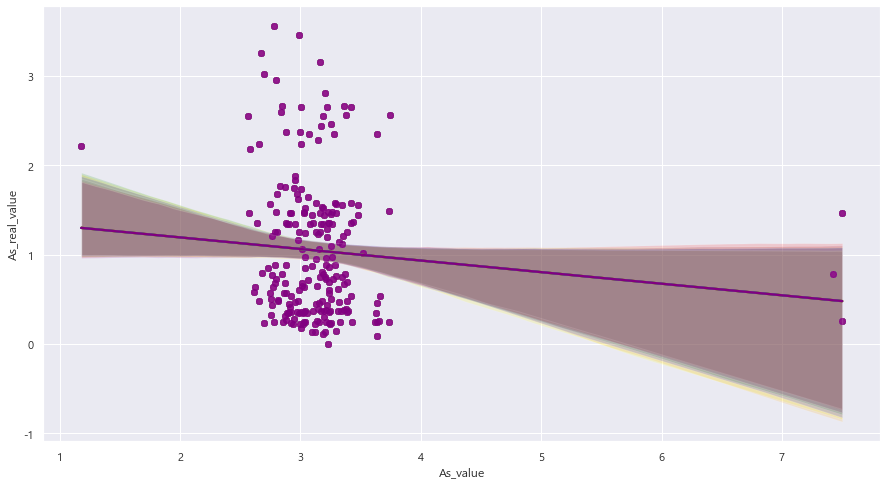

In [410]:
i = 0

for As_item in vis_As_list:
    visualization(As_item, 'As_value', 'As_real_value', i)
    i=i+1

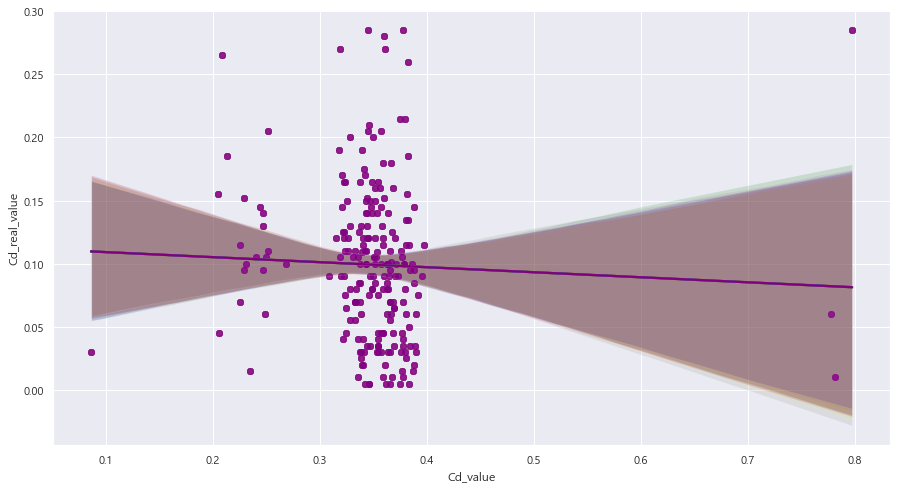

In [411]:
i = 0

for Cd_item in vis_Cd_list:
    visualization(Cd_item, 'Cd_value', 'Cd_real_value', i)
    i=i+1

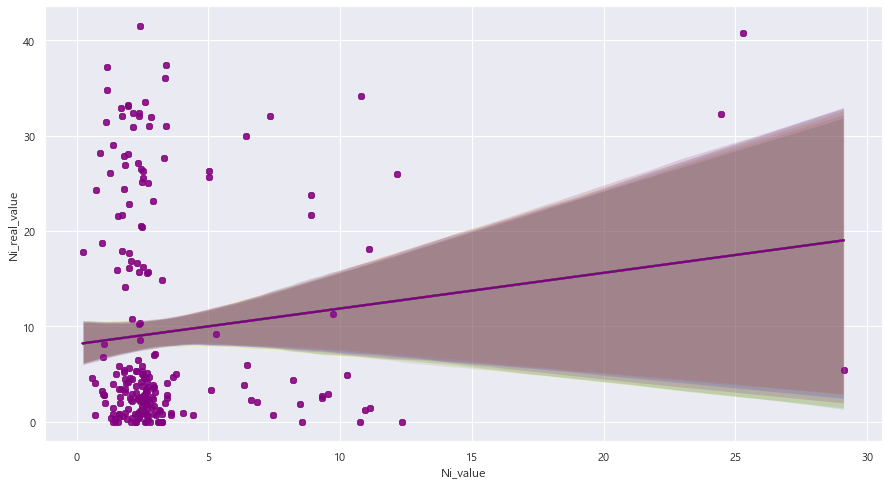

In [412]:
i = 0

for Ni_item in vis_Ni_list:
    visualization(Ni_item, 'Ni_value', 'Ni_real_value', i)
    i=i+1